In [3]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc

In [4]:
# Google colab connection
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Dataset/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/28/class-28-51.jpg  
  inflating: data/28/class-28-52.jpg  
  inflating: data/28/class-28-53.jpg  
  inflating: data/28/class-28-54.jpg  
  inflating: data/28/class-28-55.jpg  
  inflating: data/28/class-28-56.jpg  
  inflating: data/28/class-28-57.jpg  
  inflating: data/28/class-28-58.jpg  
  inflating: data/28/class-28-59.jpg  
  inflating: data/28/class-28-6.jpg  
  inflating: data/28/class-28-60.jpg  
  inflating: data/28/class-28-61.jpg  
  inflating: data/28/class-28-62.jpg  
  inflating: data/28/class-28-63.jpg  
  inflating: data/28/class-28-64.jpg  
  inflating: data/28/class-28-65.jpg  
  inflating: data/28/class-28-66.jpg  
  inflating: data/28/class-28-67.jpg  
  inflating: data/28/class-28-68.jpg  
  inflating: data/28/class-28-69.jpg  
  inflating: data/28/class-28-7.jpg  
  inflating: data/28/class-28-70.jpg  
  inflating: data/28/class-28-71.jpg  
  inflating: data/28/class-28-72.jpg  
  inflating: da

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory paths
data_dir = '/content/data'
img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator instances for train, validation, and test sets with augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split the data into 80% train and 20% validation
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# For the test set, you might need a separate directory or split
test_generator = test_datagen.flow_from_directory(
    '/content/data',  # If you have a separate test dataset
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 9504 images belonging to 38 classes.
Found 2360 images belonging to 38 classes.
Found 11864 images belonging to 38 classes.


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load the ResNet50 model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(38, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Make all layers trainable for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/50
297/297 [==============================] - 183s 499ms/step - loss: 3.7466 - accuracy: 0.0432 - val_loss: 3.6242 - val_accuracy: 0.0419 - lr: 1.0000e-05
Epoch 2/50
297/297 [==============================] - 144s 484ms/step - loss: 3.3434 - accuracy: 0.1160 - val_loss: 3.2985 - val_accuracy: 0.1242 - lr: 1.0000e-05
Epoch 3/50
297/297 [==============================] - 147s 493ms/step - loss: 2.7988 - accuracy: 0.2580 - val_loss: 2.6747 - val_accuracy: 0.2852 - lr: 1.0000e-05
Epoch 4/50
297/297 [==============================] - 145s 487ms/step - loss: 2.1955 - accuracy: 0.3972 - val_loss: 1.9797 - val_accuracy: 0.4470 - lr: 1.0000e-05
Epoch 5/50
297/297 [==============================] - 146s 492ms/step - loss: 1.6743 - accuracy: 0.5258 - val_loss: 1.4743 - val_accuracy: 0.5763 - lr: 1.0000e-05
Epoch 6/50
297/297 [==============================] - 143s 482ms/step - loss: 1.3264 - accuracy: 0.6135 - val_loss: 1.1844 - val_accuracy: 0.6525 - lr: 1.0000e-05
Epoch 7/50
297/297 [==

In [11]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')


371/371 [==============================] - 21s 57ms/step - loss: 0.1537 - accuracy: 0.9528
Test accuracy: 95.28%


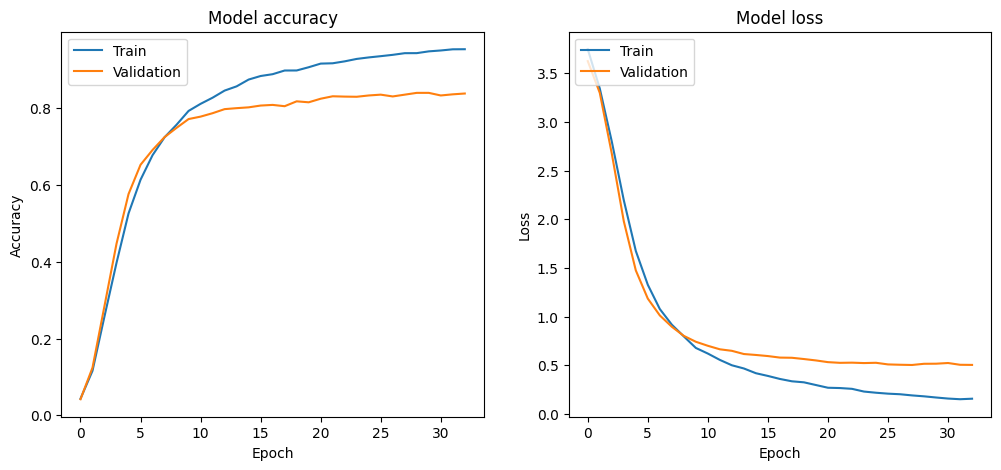

371/371 [==============================] - 21s 58ms/step


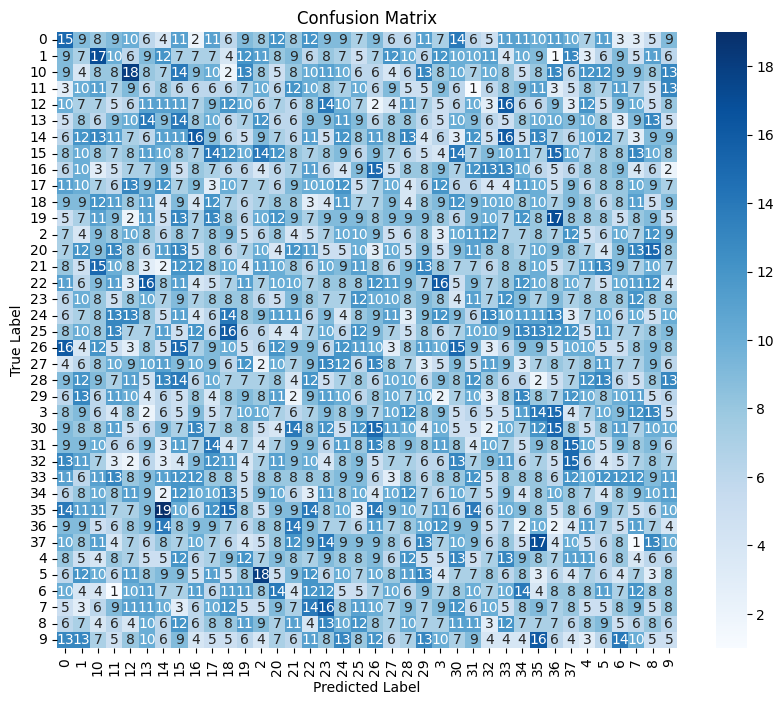

Classification Report
              precision    recall  f1-score   support

           0       0.05      0.05      0.05       320
           1       0.02      0.02      0.02       316
          10       0.02      0.02      0.02       335
          11       0.02      0.02      0.02       282
          12       0.02      0.02      0.02       301
          13       0.04      0.04      0.04       316
          14       0.04      0.03      0.03       330
          15       0.02      0.02      0.02       345
          16       0.03      0.03      0.03       280
          17       0.01      0.01      0.01       305
          18       0.02      0.02      0.02       309
          19       0.02      0.02      0.02       325
           2       0.02      0.02      0.02       293
          20       0.01      0.01      0.01       320
          21       0.03      0.02      0.03       321
          22       0.02      0.02      0.02       333
          23       0.02      0.02      0.02       311
     

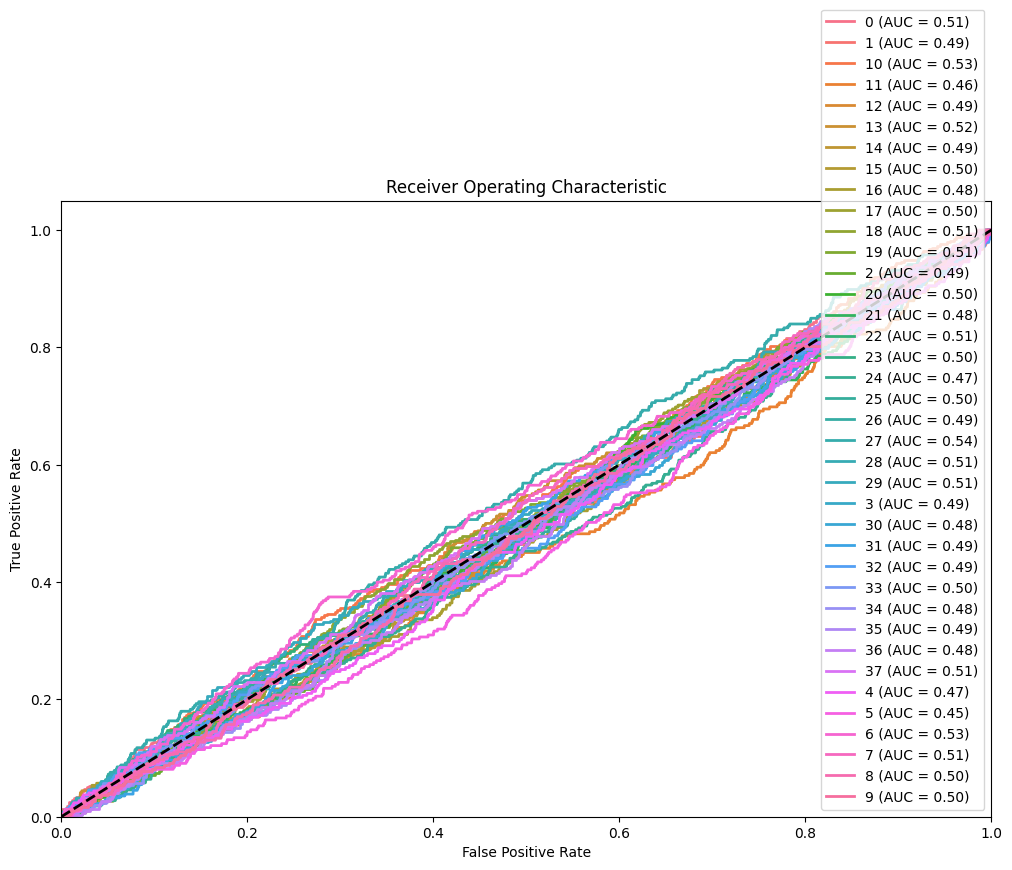

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

# 1. Plotting loss and accuracy per epoch
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history(history)

# 2. Generate predictions on the test set
# test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# 3. Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = list(test_generator.class_indices.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Generate and print the classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=cm_plot_labels))

# 5. Compute and plot the ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(cm_plot_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(cm_plot_labels))
for i, color in zip(range(len(cm_plot_labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(cm_plot_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()